# <b>Relatório do Trabalho 1 de AM1</b>  
> **Membros:**  
  Ana Luisa Conrado Ferreira de Oliveira, 801583  
  Caio Obatake Watari Gonçalves Cadini, 800383  
  Lucas Abbiati Pereira, 801572  
  Vinícius Matheus Romualdo Santos, 801258  
  Vitor Enzo Araujo Costa,  802123  
  
## **Objetivos:**  
O processamento de áudio é uma das tarefas mais difíceis da ciência de dados comparada ao processamento de imagem e outras técnicas de classificação. Uma de suas aplicações é a Classificação de Gêneros Musicais que tem como foco classificar arquivos de audio nas categorias as quais ele pertence. Essa aplicação é muito utilizada em aplicativos de *streaming* de músicas como o Spotify e o Soundcloud ou como um produto para reconhecimento de música como o Shazam. Portanto, o objetivo desse trabalho é estudar como analisar músicas em Python e utilizar o que foi aprendido para classificar as músicas em diferentes gêneros.

## **Introdução ao Processamento de Áudio**  
(texto)


## **Importando as bibliotecas**

In [ ]:
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=a7c014b24cc58280456f107513f4584854ee4ba89060faa1d7ccb3b4d1bb451b
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [61]:
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from tempfile import TemporaryFile
import os
import math
import pickle
import random
import operator
from google.colab import files
import io
from sklearn.model_selection import cross_validate, train_test_split
from sklearn import datasets
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
import sklearn.ensemble as ske
import sklearn.metrics as skm

In [ ]:
upload = files.upload()

Saving blues.00000.wav to blues.00000.wav


## **Extração de Features**  
A extração das *features* de dados de áudio é um processo muito complexo e que possui várias técnicas. Nessa etapa, iremos carregar, para a memória, os dados dos 10 diretórios das respectivas categorias e extrair as *features* de cada arquivo de audio e salvar as características em binário em um arquivo de formato de extensão DAT. Para fins de estudo, utilizaremos um método chamado Mel Frequency Cepstral Coefficients (MFCC) que resultará .  

## **Mel Frequency Cepstral Coefficients**  
A extração de *features* em arquivos de áudio consiste em identificar atributos como dados linguísticos e ruídos, por exemplo. Essas *features* são classificadas dentro de 3 categorias:  


1.   Alto nível: Relacionadas à atributos pertencentes às letras de músicas, como acordes, ritmos, melodia, entre outros;
2.   Médio nível: Atributos semelhantes à batidas, padrões de flutuações semelhantes ao tom e MFCCs;
3.   Baixo nível: Inclui energia e a taxa de *zero-crossing*.  

Para isso, importamos o MFCC da biblioteca "python_speech_features" que será responsável por fazer todo o trabalho de extrair características de médio e baixo nível utilizando o seguinte passo a passo:  

1.   Geralmente os arquivos de áudio duram segundos, podendo chegar a minutos, e durante esse intervalo o *pitch* e a frequência mudam a todo momento. Então, o primeiro passo é dividir os áudios em pequenos *frames* com 20 a 40ms de duração.  
2.   Após dividir os arquivos, o algoritmo tenta extrair diferentes frequências de cada *frame*. Para isso, como temos um intervalo muito pequeno, o algoritmo considera aquele intervalo como possuindo uma única frequência.  
3.   Depois, é separado os dados linguísticos dos ruídos.  
4.   Para descartar os ruídos basta obter a Transformada Discreta dos Cosenos (DCT) das frequências.

Criando um arquivo de python chamado "extracao_de_features_wav.py", iremos iterar todo o diretório de categorias e em cada categorias vamos ler para a memória o arquivo de áudio, extrair as caracteristicas de MFCC e armazená-las em um arquivo binário utilizando o módulo python "pickle". O código a seguir apresenta o conteúdo do arquivo PY.  



In [ ]:
path = 'Data/genres_original'
f = open("mydataset.dat", "wb")
i = 0
for folder in os.listdir(path):
    print(folder)
    i += 1
    if i == 11:
        break
    for file in os.listdir(path+"/"+folder):
        print(file)
        try:
            (rate, sig) = wav.read(path+"/"+folder+"/"+file)
            mfcc_feat = mfcc(sig, rate, winlen = 0.020, appendEnergy=False)
            covariance = np.cov(np.matrix.transpose(mfcc_feat))
            mean_matrix = mfcc_feat.mean(0)
            feature = (mean_matrix, covariance, i)
            pickle.dump(feature, f)
        except Exception as e:
            print("Got an exception: ", e, 'in folder: ', folder, ' filename: ', file)
f.close()

## **Divisão dos Conjuntos de Treino e Teste**  
Agora que as *features* foram extraídas e armazenadas em um arquivo binário de extensão DAT, temos que implementar uma função que leia um arquivo e copie todos os dados para um *dataframe*. Existem diversas formas de realizar a divisão dos conjuntos de teste e treino, nesse trabalho serão utilizados os métodos de *holdout* e de validação cruzada.  
No código abaixo, utilizamos a função "loadDataset_holdout" pra realizar o holdout dos dados...

In [ ]:
dataset = []

def loadDataset_holdout(filename, split, trset, teset):
    with open(filename,'rb') as f:
        while True:
            try:
               dataset.append(pickle.load(f))
            except EOFError:
               f.close()
               break
    for x in range(len(dataset)):
        if random.random() < split:
          trset.append(dataset[x])
        else:
          teset.append(dataset[x])

trainingSet = []
testSet = []
loadDataset_holdout('mydataset.dat', 0.75, trainingSet, testSet)

... e o código da validação cruzada está definido a seguir.

In [ ]:
#Carregar dados para estabeler X e y
data = pd.read_csv('/content/features_30_sec.csv')
########################################

outputs = []
data_list = data.values.tolist()

#Definindo X e y
for i in data_list:
  feature_output = i.pop()
  outputs.append(feature_output)

def Dataset_cross_validation(modelo, X1, y1, foldnumber=5):
   pontuacao = ['accuracy', 'precision', 'recall', 'f1']
   resultados = cross_validate(modelo, X1, y1, cv = foldnumber, scoring = pontuacao)

   return{"Training Accuracy scores": resultados['train_accuracy'],
              "Mean Training Accuracy": resultados['train_accuracy'].mean()*100,
              "Training Precision scores": resultados['train_precision'],
              "Mean Training Precision": resultados['train_precision'].mean(),
              "Training Recall scores": resultados['train_recall'],
              "Mean Training Recall": resultados['train_recall'].mean(),
              "Training F1 scores": resultados['train_f1'],
              "Mean Training F1 Score": resultados['train_f1'].mean(),
              "Validation Accuracy scores": resultados['test_accuracy'],
              "Mean Validation Accuracy": resultados['test_accuracy'].mean()*100,
              "Validation Precision scores": resultados['test_precision'],
              "Mean Validation Precision": resultados['test_precision'].mean(),
              "Validation Recall scores": resultados['test_recall'],
              "Mean Validation Recall": resultados['test_recall'].mean(),
              "Validation F1 scores": resultados['test_f1'],
              "Mean Validation F1 Score": resultados['test_f1'].mean()
              }

def Dataset_plot_results(x_graf, y_graf, titulo, )

<class 'numpy.ndarray'>


## **Treinando o Modelo**  
Pronto, separamos o dataframe nos conjuntos de treino e teste e agora precisamos alimentar os modelos com os dados de treino e depois realizar as predições utilizando os dados de teste. Também calcularemos as métricas de avaliação de desempenho dos algoritmos e analisaremos os resultados obtidos.

In [ ]:
length = len(testSet)
predictions = []
for i in range(length):
  predictions.append

## **Visualização dos dados e seleção dos atributos**

Seleção de atributos consiste na eliminação de ruídos presentes em um conjuto de dados, isto é, atributos inrrelevantes à classificação e dados inconsistentes. Isso tornará o conjunto de dados mais consistente o que:
1.  Previne que o modelo aprenda com ruídos.
2.  Aumenta a acurácia do modelo.
3.  Reduz o tempo de treinamento.



In [ ]:
# Lendo o arquivo cvs contendo as features extraidas das amostras de 30 segundos
data = pd.read_csv('/content/features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
col = data.columns
print(col)

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

Em uma análise superficial dos dados, notamos que a coluna filename não possui informações relevantes à classificação, portanto, podemos descarta-la.

In [ ]:
list = ['filename']
data = data.drop(list,axis = 1 )
data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


**Método Variance Threshold**

Também notamos que length aparentemente tem um valor constante, usando o seletor de features variance threshold podemos verificar quais colunas possuem variância igual a 0 e, assim, descarta-las, uma vez que não serão relevantes ao treinamento do modelo.

In [ ]:
# separando os atributos dependentes e independetes
X = data.iloc[:, 0:58]
y = data.iloc[:, -1]

# separando entre treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# aplicando o metodo de variance threshold
var_thres = VarianceThreshold(threshold=0)
var_thres.fit(X_train)
var_thres.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

Surpeendentemente, nenhuma das colunas possui variância 0, portanto, não iremos descarta-las momentaneamente.

**Análise de valores faltantes**

Podemos aplicar o método isnull() ao dataset para conferir a existência de valores faltantes no que se refere a cada um dos objetos analisados

In [ ]:
data.isnull().sum()

length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var                  0
mfcc9_mean    

**Método Information gain**

Agora podemos aplicar o teste information gain para filtrar os atributos que tem baixo valor de ganho de informação.

<Axes: >

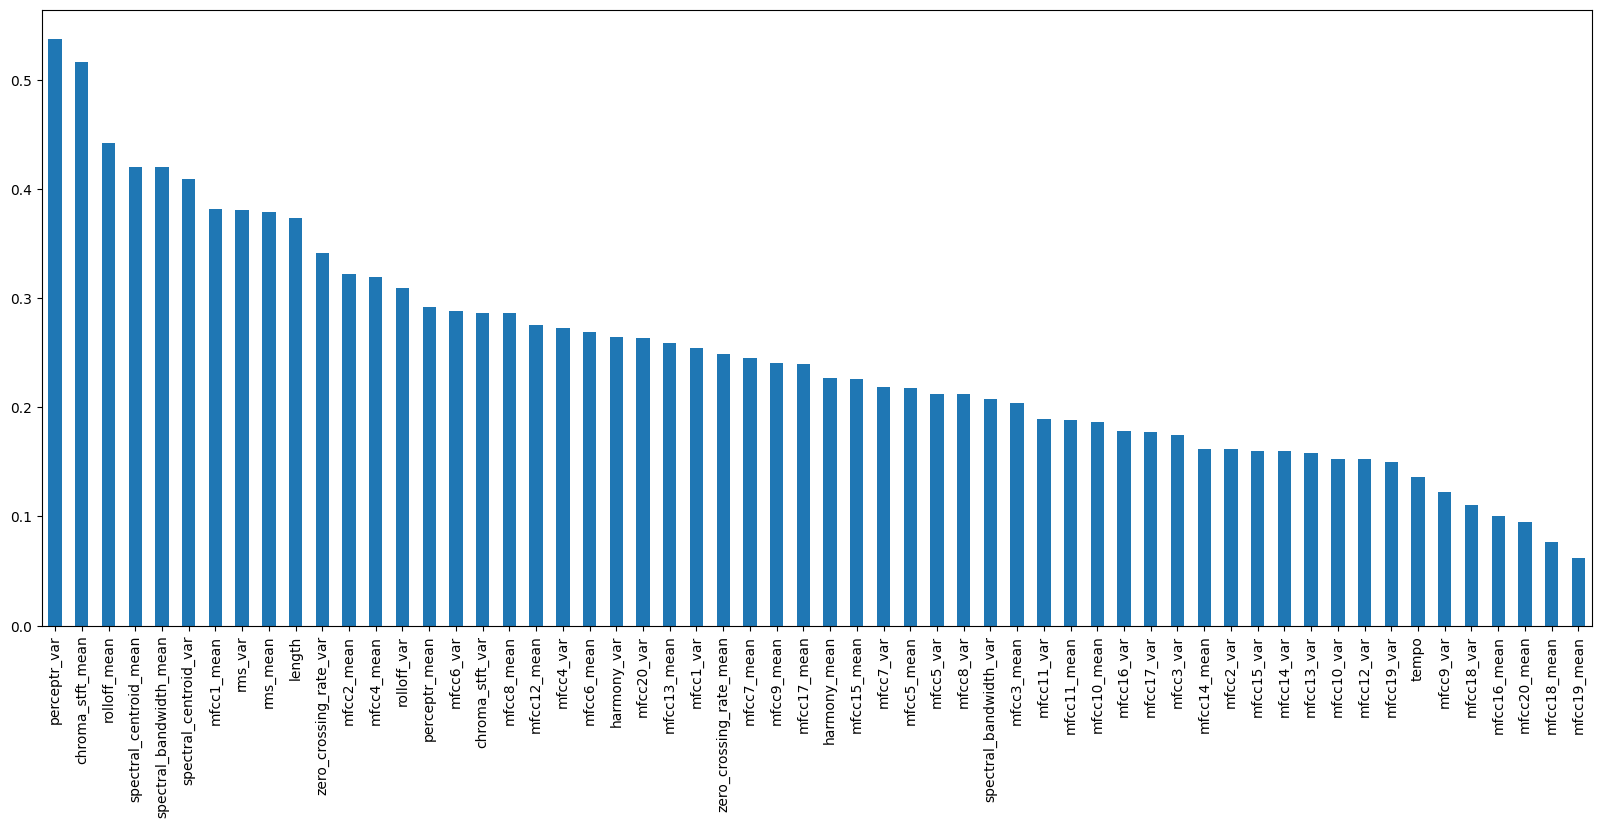

In [ ]:
mutual_info = mutual_info_classif(X, y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
cor = data.corr()

plt.figure(figsize = (20, 12))
sns.heatmap(cor, annot = True)

<ipython-input-15-715050d5b16f>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr()


<Axes: >

**Mapa de Calor de Correlação**

Avançando um pouco mais na análise dos dados iremos utilizar um Mapa de Correlação para nos ajuda a identificar correlações entre as features.

Utilizaremos especificamente as variáveis baseadas nas médias das features para uma visualização mais abrangente.


<ipython-input-47-1a1b890ed4d9>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


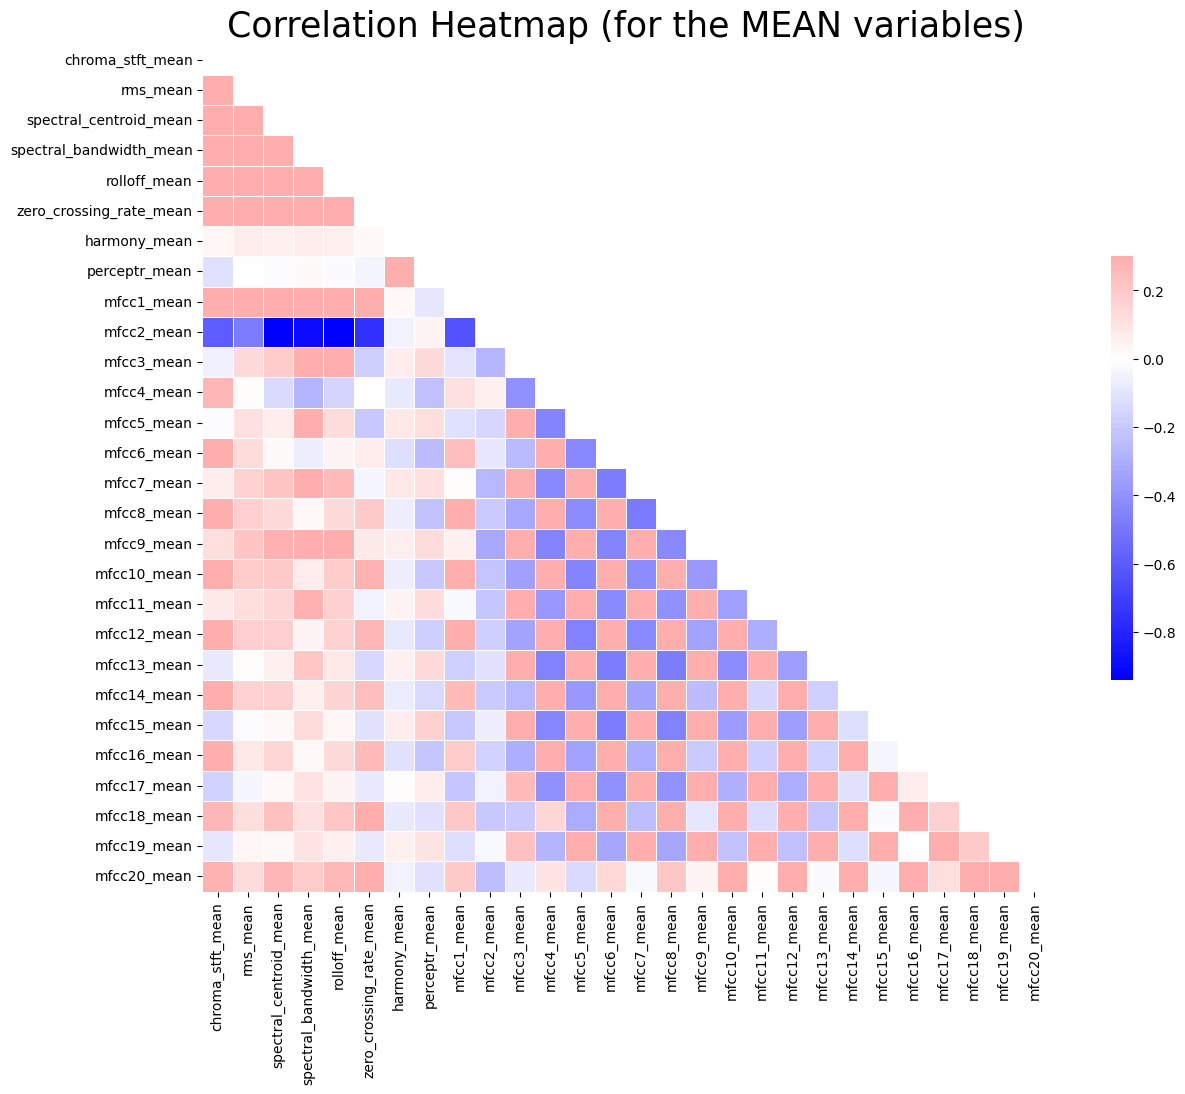

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculando a matrix de correlação
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

# Gerando uma máscara para o triângulo superior
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Configurando a figura
f, ax = plt.subplots(figsize=(16, 11));

# Gerando um mapa de cores divergentes
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Desenhando o mapa
sns.heatmap(corr, mask=mask, cmap="bwr", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

**PCA (Principal Component Analysis)**

Utilizaremos a Análise de Componentes Principais, para tentar reduzir a dimensionalidade do nosso conjunto de dados, tentando encontrar possíveis conjuntos de gêneros. Onde iremos transformar um conjunto de variáveis ​​correlacionadas em um novo conjunto de variáveis ​​não correlacionadas chamadas de componentes principais.




**1° passo: Normalização dos dados**

É importante que todas as variáveis tenham escalas **comparáveis** antes de aplicar o PCA.

In [ ]:
from sklearn import preprocessing

data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalizando X
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

X.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.362279,0.695468,0.318188,0.101983,0.314117,0.040233,0.422879,0.109789,0.385532,0.102567,...,0.564186,0.112704,0.541287,0.057615,0.422444,0.082450,0.487950,0.109503,0.599189,0.078255
1,0.343622,0.793392,0.230894,0.085580,0.248405,0.121475,0.436889,0.296867,0.353329,0.342717,...,0.570198,0.120353,0.574685,0.118286,0.448184,0.102997,0.548800,0.099081,0.579640,0.075947
2,0.389832,0.640692,0.433652,0.099064,0.254261,0.049046,0.325334,0.095712,0.289224,0.088981,...,0.622467,0.081898,0.331003,0.085962,0.370988,0.116420,0.453724,0.087317,0.501381,0.045405
3,0.473508,0.777954,0.345856,0.229160,0.129376,0.058253,0.267404,0.227566,0.181068,0.171001,...,0.565151,0.091876,0.484549,0.092509,0.460684,0.068975,0.538690,0.062612,0.468060,0.048168
4,0.277759,0.681062,0.219641,0.083075,0.327270,0.110761,0.325514,0.113536,0.357017,0.180228,...,0.383289,0.200462,0.410225,0.156424,0.403875,0.120300,0.424652,0.130173,0.233047,0.094836


**2° passo: Aplicação do PCA**

Agora, que temos as variáveis dependentes normalizadas podemos aplicar o PCA. Primeiro calculando a matriz de covariância, depois decompondo-a para encontrar os autovalores e autovetores que correspondem, respectivamente, aos eixos do novo espaço (componentes principais) e a quantidade de variabilidade explicada por cada componente principal.

In [ ]:
from sklearn.decomposition import PCA

# Cria o PCA com 2 componentes
pca = PCA(n_components=2)

# Transforma "X" em dois componentes principais
principalComponents = pca.fit_transform(X)

# cria um dataframe para os componentes
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1',
                                      'principal component 2'])


**3° passo: Projeção dos dados**

Os dados originais são projetados no novo espaço dos componentes principais.

In [ ]:
# concatena o
finalDf = pd.concat([principalDf, y], axis = 1)

array = pca.explained_variance_ratio_
array

array([0.24644968, 0.22028192])

In [ ]:
soma = 0
for valor in array:
    soma = soma + valor
soma

0.6833523495297911

Pode ser necessário um número maior de componentes principais para capturar uma porcentagem significativa da variabilidade total dos dados.

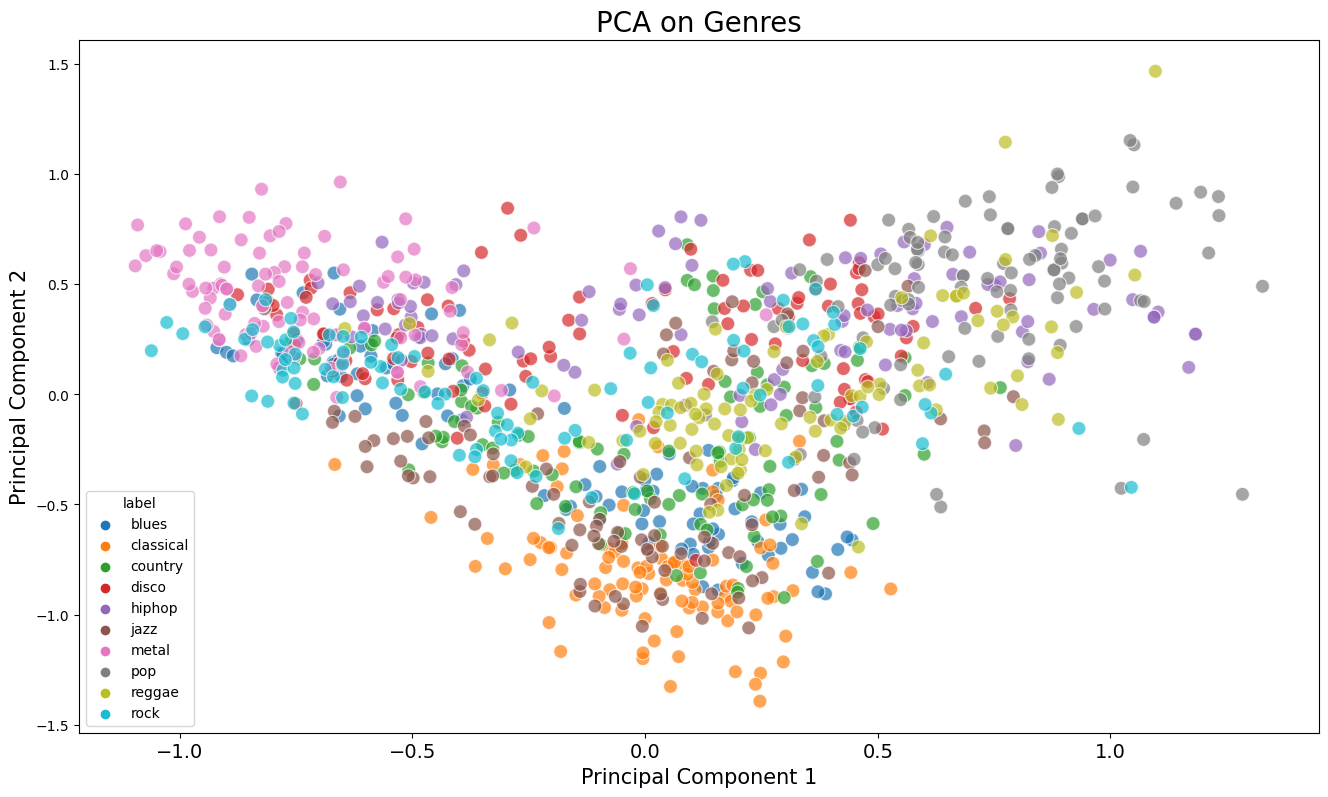

In [48]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2",
                data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")

Porém, ao aumentar os números de componentes, verificamos que a taxa de variância não aumentou tanto. E o aumento dos componentes acabou trazendo preocupações com um possível overfitting do modelo e uma dificil interpretabilidade.

**Visualizacao do audio**


In [ ]:
import librosa
import librosa.display
import IPython.display as i

y, s = librosa.load('/content/blues.00000.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', s, '\n')

print('Check Len of Audio:', 661794/22050)

y: [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


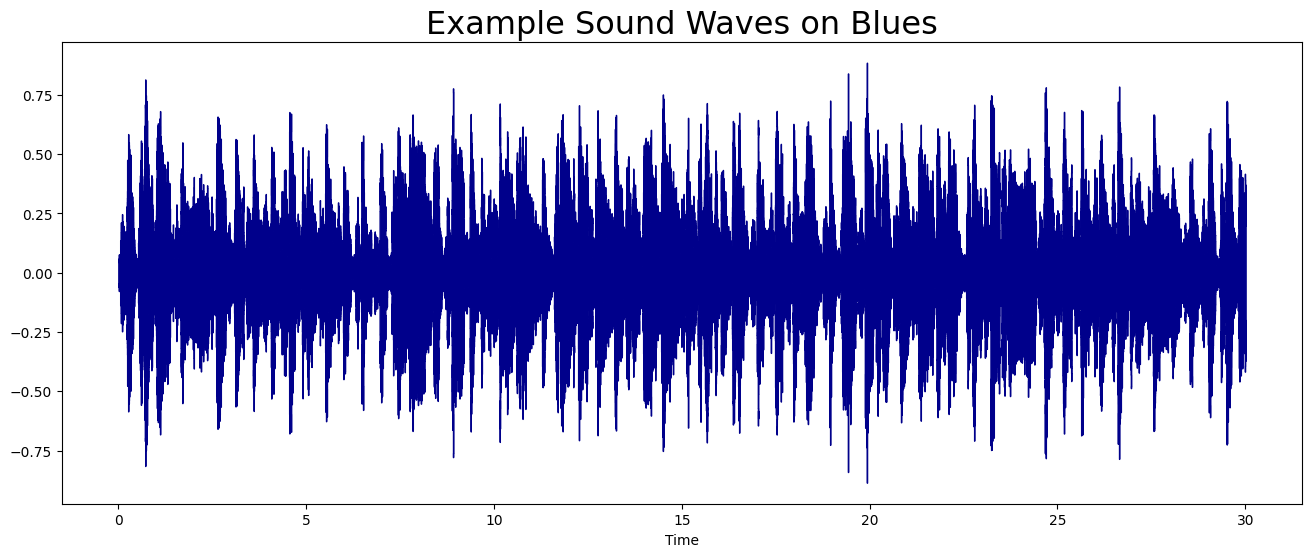

In [ ]:
plt.figure(figsize = (16, 6))
audio, _ = librosa.effects.trim(y)
librosa.display.waveshow(y = audio, sr = s, color = "#00008B");
plt.title("Example Sound Waves on Blues", fontsize = 23);

**Dividindo em dados de treino e teste**

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV,mutual_info_regression
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

In [115]:
y = data.label
X = data

#Use `label` to split data evenly and drop `label` column after split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    stratify=data.label, random_state=77)
X_train.drop('label',axis=1,inplace=True)
X_test.drop('label',axis=1,inplace=True)

In [116]:
min_max_scaler = preprocessing.MinMaxScaler()

X_train_scaled = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = min_max_scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

## **Ajuste de modelo inicial e eliminação recursiva de features**

Agora, nos iremos ajustar nossos dados de treino para o classificador xgboost primeiro, e então nos iremos fazer RFE (Recursive Feature Elimination - RFE) para checar qual variáveis podem ser eliminadas.

**1° passo: Codificação dos rótulos de destino**

Para aplicar o RFE precisamos codificar o rótulos alvo.


In [129]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)

**2° passo: Criação do classificador**

Criaremos um classificador para o nosso método RFE aplicar em suas iterações, utilizaremos o XGBoost para servir de "estimator" com a configuração de métrica de avaliação definida como 'merror', que representa a taxa de erro de classificação.

In [105]:
estimator = XGBClassifier(eval_metric='merror')

**3° passo: Aplicação do RFE**

O "RFECV" utilizará o classificador "estimator" definido anteriormente e contém parâmetros como "step" (passo de eliminação de características), "cv" (número de dobras na validação cruzada), "scoring" (métrica de avaliação) e "verbose" (exibição de informações durante o processo).

Aplicaremos o método "fit" do objeto "rfecv" aos dados de treinamento "X_train" e aos rótulos de destino codificados "y_train". Esse método executa a seleção de características recursivas, avaliando o desempenho do classificador em cada iteração e eliminando as características menos relevantes.

In [106]:
rfecv = RFECV(estimator, step=1, cv=5,scoring='accuracy',verbose=1)
rfecv.fit(X_train, y_train)

Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 fe

RFECV(cv=5,
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='merror',
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...),
      scoring='accuracy', verbose=1)

Após a execução do RFE, teremos um array contendo indicações para as features que podem ser removidas do nossos conjuntos de dados.

In [107]:
features_drop_array = list(np.where(rfecv.support_ == False)[0])
X_train.columns[features_drop_array]

Index(['mfcc9_var', 'mfcc11_var', 'mfcc19_mean'], dtype='object')

In [ ]:
X_train.drop(X_train.columns[features_drop_array], axis=1, inplace=True)
X_test.drop(X_test.columns[features_drop_array], axis=1, inplace=True)

## **Treinamento do modelo**

Nós usaremos o classificador XGBoost para classificar.

In [112]:
model = XGBClassifier(n_estimators=1000)
model.fit(X_train,y_train,eval_metric='merror')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Analisando a acurária:

In [130]:
y_train

array([0, 4, 3, 8, 6, 5, 7, 1, 0, 1, 0, 2, 5, 6, 8, 2, 6, 3, 5, 9, 8, 5,
       9, 0, 3, 7, 9, 6, 2, 7, 8, 6, 1, 4, 9, 1, 3, 4, 8, 1, 0, 7, 1, 0,
       1, 5, 2, 5, 6, 2, 1, 7, 6, 9, 8, 2, 3, 3, 5, 5, 6, 1, 4, 8, 5, 7,
       6, 4, 5, 0, 5, 3, 8, 3, 6, 3, 9, 7, 2, 9, 8, 6, 9, 6, 5, 1, 4, 9,
       4, 2, 6, 8, 0, 4, 7, 0, 8, 0, 2, 1, 1, 0, 5, 5, 7, 9, 5, 6, 0, 8,
       9, 7, 9, 9, 6, 0, 5, 4, 5, 5, 2, 3, 8, 6, 9, 6, 7, 1, 6, 3, 5, 2,
       9, 9, 4, 8, 2, 6, 4, 5, 2, 2, 5, 0, 4, 3, 1, 5, 0, 3, 6, 4, 6, 1,
       2, 9, 0, 5, 9, 8, 4, 4, 8, 2, 3, 1, 4, 5, 5, 7, 0, 0, 6, 8, 8, 9,
       0, 5, 9, 3, 4, 1, 2, 1, 0, 2, 6, 1, 6, 6, 4, 8, 6, 8, 0, 7, 8, 0,
       5, 8, 1, 9, 1, 0, 4, 3, 8, 3, 4, 2, 0, 7, 0, 8, 2, 2, 5, 4, 4, 1,
       7, 3, 0, 6, 7, 5, 3, 2, 1, 6, 2, 8, 0, 6, 0, 9, 1, 9, 4, 6, 1, 5,
       8, 1, 5, 1, 8, 4, 7, 0, 9, 0, 7, 7, 4, 4, 3, 6, 2, 3, 3, 9, 3, 3,
       3, 8, 9, 7, 8, 0, 5, 4, 2, 8, 5, 4, 0, 1, 0, 1, 6, 7, 4, 7, 6, 7,
       2, 2, 4, 2, 0, 2, 5, 8, 0, 2, 6, 8, 4, 7, 5,

In [132]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
target_names = sorted(set(y))

y_test = le.fit_transform(y_test)
print(target_names)

print(f'Training accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Training:\n {classification_report(y_train, y_pred_train, target_names=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_pred_test)}')
print(f'Testing:\n {classification_report(y_test, y_pred_test, target_names=target_names)}')

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Training accuracy: 0.9988888888888889
Training:
               precision    recall  f1-score   support

       blues       1.00      1.00      1.00        90
   classical       1.00      1.00      1.00        90
     country       1.00      1.00      1.00        90
       disco       1.00      1.00      1.00        90
      hiphop       1.00      1.00      1.00        90
        jazz       1.00      1.00      1.00        90
       metal       0.99      1.00      0.99        90
         pop       1.00      1.00      1.00        90
      reggae       1.00      1.00      1.00        90
        rock       1.00      0.99      0.99        90

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900

Testing accuracy: 0.77
Testing:
               precision    recall  f1-score   support

       bl

E a matriz de confusão dos dados de teste:

<Axes: >

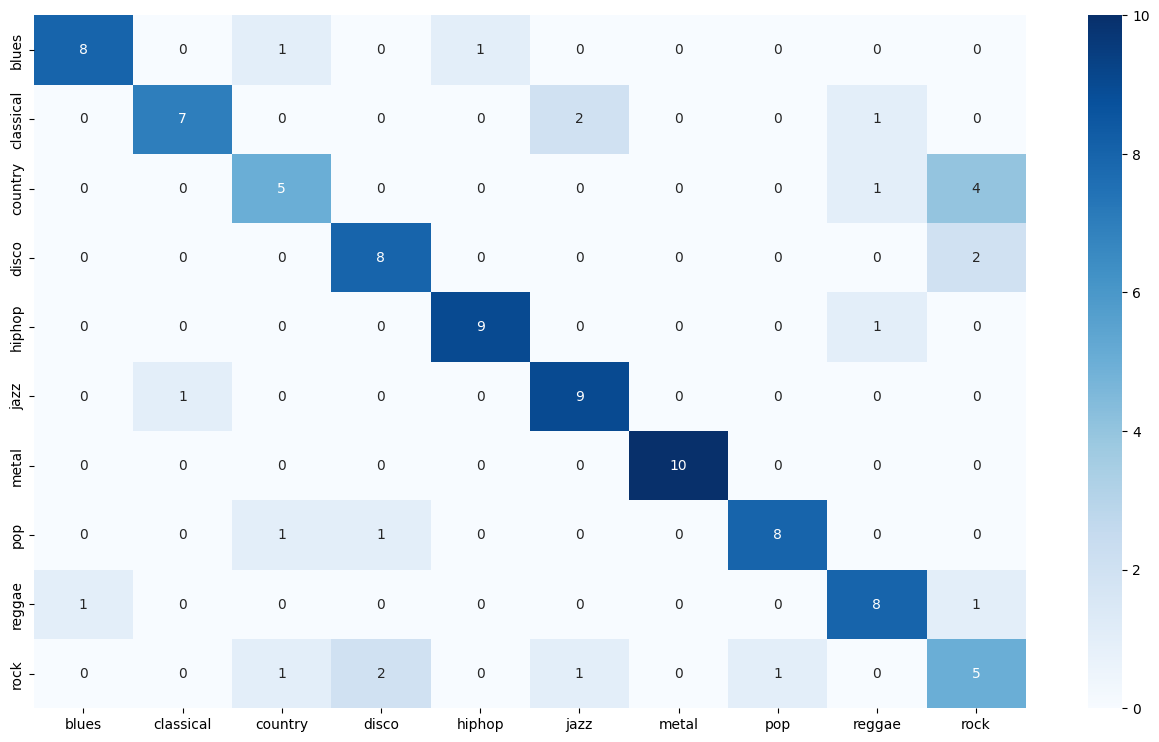

In [133]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (16, 9))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

Nós devemos ver que nós conseguimos 99% de acurácia para os dados de treino, mas somente 78% para os dados de teste. Obviamente, nos estamos vendo nosso modelo sofrer com Overfitting. A seguir, adicionaremos parâmetros de regularização e ajustaremos outros parâmetros para reduzir esse problema.

# Ajuste de hiperparâmetros

A seguir, usaremos a biblioteca `hyperopt` para ajudar a ajustar os parâmetros. Os parâmetros podem variar para cada execução

In [135]:
# Importar bibliotecas necessárias
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Definir o espaço de busca de hiperparâmetros
space = {
    'n_estimators': hp.quniform('n_estimators', 0, 3000, 1),
    'reg_lambda': hp.quniform('reg_lambda', 0, 500, 1),
}

# Definir a função objetivo para otimização de hiperparâmetros
def objective(space):
    # Criar o classificador XGBoost com os hiperparâmetros do espaço
    clf = XGBClassifier(
        n_estimators=int(space['n_estimators']),
        reg_lambda=int(space['reg_lambda']),
    )

    # Definir os conjuntos de avaliação
    evaluation = [(X_train, y_train), (X_test, y_test)]

    # Treinar o classificador e avaliar o desempenho
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10, verbose=False)

    # Realizar previsões no conjunto de teste
    pred = clf.predict(X_test)

    # Calcular a acurácia do modelo
    accuracy = accuracy_score(y_test, pred)

    # Retornar a perda (negativo da acurácia) e o status
    return {'loss': -accuracy, 'status': STATUS_OK}

# Criar objeto Trials() para acompanhar os resultados
trials = Trials()

# Executar a otimização de hiperparâmetros
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  1%|          | 1/100 [00:22<37:26, 22.69s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  2%|▏         | 2/100 [00:49<40:39, 24.90s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  3%|▎         | 3/100 [01:20<45:15, 27.99s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  4%|▍         | 4/100 [01:33<35:16, 22.05s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  5%|▌         | 5/100 [01:56<35:31, 22.44s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  6%|▌         | 6/100 [02:30<41:00, 26.17s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  7%|▋         | 7/100 [02:38<31:34, 20.37s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  8%|▊         | 8/100 [02:53<28:42, 18.72s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  9%|▉         | 9/100 [03:05<25:08, 16.58s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 10%|█         | 10/100 [03:34<30:28, 20.31s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 11%|█         | 11/100 [03:47<26:54, 18.14s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 12%|█▏        | 12/100 [04:16<31:14, 21.30s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 13%|█▎        | 13/100 [04:37<30:57, 21.35s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 14%|█▍        | 14/100 [04:59<30:50, 21.52s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 15%|█▌        | 15/100 [05:23<31:42, 22.38s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 16%|█▌        | 16/100 [05:41<29:17, 20.92s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 17%|█▋        | 17/100 [06:07<30:57, 22.38s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 18%|█▊        | 18/100 [06:32<31:48, 23.28s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 19%|█▉        | 19/100 [06:52<29:59, 22.22s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 20%|██        | 20/100 [07:21<32:25, 24.32s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 21%|██        | 21/100 [07:35<27:49, 21.13s/trial, best loss: -0.75]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 22%|██▏       | 22/100 [07:39<20:49, 16.02s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 23%|██▎       | 23/100 [07:41<15:15, 11.89s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 24%|██▍       | 24/100 [07:44<11:44,  9.27s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 25%|██▌       | 25/100 [08:01<14:31, 11.62s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 26%|██▌       | 26/100 [08:14<14:47, 11.99s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 27%|██▋       | 27/100 [08:23<13:28, 11.07s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 28%|██▊       | 28/100 [08:30<11:54,  9.92s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 29%|██▉       | 29/100 [08:47<14:13, 12.03s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 30%|███       | 30/100 [09:04<15:43, 13.48s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 31%|███       | 31/100 [09:18<15:30, 13.49s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 32%|███▏      | 32/100 [09:35<16:36, 14.65s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 33%|███▎      | 33/100 [09:41<13:27, 12.06s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 34%|███▍      | 34/100 [09:57<14:24, 13.10s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 35%|███▌      | 35/100 [10:03<11:57, 11.05s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 36%|███▌      | 36/100 [10:09<10:18,  9.66s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 37%|███▋      | 37/100 [10:28<12:52, 12.26s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 38%|███▊      | 38/100 [10:41<13:07, 12.70s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 39%|███▉      | 39/100 [10:52<12:09, 11.97s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 40%|████      | 40/100 [11:08<13:10, 13.17s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 41%|████      | 41/100 [11:25<14:03, 14.30s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 42%|████▏     | 42/100 [11:31<11:33, 11.95s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 43%|████▎     | 43/100 [11:45<11:56, 12.57s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 44%|████▍     | 44/100 [11:57<11:25, 12.24s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 45%|████▌     | 45/100 [12:08<11:00, 12.00s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 46%|████▌     | 46/100 [12:13<08:56,  9.93s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 47%|████▋     | 47/100 [12:24<09:03, 10.25s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 48%|████▊     | 48/100 [12:41<10:44, 12.40s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 49%|████▉     | 49/100 [13:06<13:32, 15.92s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 50%|█████     | 50/100 [13:07<09:35, 11.51s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 51%|█████     | 51/100 [13:15<08:30, 10.42s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 52%|█████▏    | 52/100 [13:42<12:17, 15.37s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 53%|█████▎    | 53/100 [14:00<12:47, 16.33s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 54%|█████▍    | 54/100 [14:17<12:41, 16.55s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 55%|█████▌    | 55/100 [14:25<10:27, 13.94s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 56%|█████▌    | 56/100 [14:46<11:49, 16.14s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 57%|█████▋    | 57/100 [14:58<10:40, 14.91s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 58%|█████▊    | 58/100 [15:06<08:57, 12.80s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 59%|█████▉    | 59/100 [15:39<12:45, 18.67s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 60%|██████    | 60/100 [15:46<10:07, 15.19s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 61%|██████    | 61/100 [15:57<09:11, 14.15s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 62%|██████▏   | 62/100 [16:15<09:31, 15.04s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 63%|██████▎   | 63/100 [16:37<10:41, 17.35s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 64%|██████▍   | 64/100 [17:00<11:26, 19.07s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 65%|██████▌   | 65/100 [17:18<10:52, 18.64s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 66%|██████▌   | 66/100 [17:29<09:17, 16.40s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 67%|██████▋   | 67/100 [17:43<08:39, 15.73s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 68%|██████▊   | 68/100 [17:54<07:31, 14.12s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 69%|██████▉   | 69/100 [17:56<05:26, 10.54s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 70%|███████   | 70/100 [18:01<04:28,  8.97s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 71%|███████   | 71/100 [18:06<03:40,  7.62s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 72%|███████▏  | 72/100 [18:16<03:55,  8.43s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 73%|███████▎  | 73/100 [18:34<05:08, 11.42s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 74%|███████▍  | 74/100 [18:40<04:11,  9.67s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 75%|███████▌  | 75/100 [18:49<03:57,  9.51s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 76%|███████▌  | 76/100 [19:05<04:33, 11.38s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 77%|███████▋  | 77/100 [19:17<04:26, 11.60s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 78%|███████▊  | 78/100 [19:24<03:48, 10.37s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 79%|███████▉  | 79/100 [19:36<03:44, 10.67s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 80%|████████  | 80/100 [19:54<04:16, 12.82s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 81%|████████  | 81/100 [19:56<03:03,  9.65s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 82%|████████▏ | 82/100 [20:01<02:26,  8.12s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 83%|████████▎ | 83/100 [20:18<03:06, 10.94s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 84%|████████▍ | 84/100 [20:21<02:19,  8.69s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 85%|████████▌ | 85/100 [20:27<01:54,  7.66s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 86%|████████▌ | 86/100 [20:34<01:44,  7.46s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 87%|████████▋ | 87/100 [20:42<01:39,  7.69s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 88%|████████▊ | 88/100 [20:52<01:41,  8.49s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 89%|████████▉ | 89/100 [20:58<01:23,  7.60s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 90%|█████████ | 90/100 [21:17<01:49, 10.97s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 91%|█████████ | 91/100 [21:24<01:28,  9.81s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 92%|█████████▏| 92/100 [21:50<01:57, 14.67s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 93%|█████████▎| 93/100 [21:57<01:27, 12.53s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 94%|█████████▍| 94/100 [22:00<00:56,  9.45s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 95%|█████████▌| 95/100 [22:12<00:52, 10.43s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 96%|█████████▌| 96/100 [22:35<00:56, 14.12s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 97%|█████████▋| 97/100 [22:48<00:41, 13.70s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 98%|█████████▊| 98/100 [23:15<00:35, 17.64s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 99%|█████████▉| 99/100 [23:27<00:16, 16.17s/trial, best loss: -0.77]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



100%|██████████| 100/100 [23:41<00:00, 14.22s/trial, best loss: -0.77]


In [136]:
print(f"best params: {best_hyperparams}")

best params: {'n_estimators': 2308.0, 'reg_lambda': 1.0}


In [140]:
model1 = XGBClassifier(n_estimators=2308, reg_lambda=1)
model1.fit(X_train,y_train,eval_metric='merror')
y_pred_test1 = model1.predict(X_test)
print(f"accuracy: {accuracy_score(y_test,y_pred_test1)}")
print(f'New tuned model:\n {classification_report(y_test, y_pred_test1, target_names=target_names)}')


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


accuracy: 0.78
New tuned model:
               precision    recall  f1-score   support

       blues       0.89      0.80      0.84        10
   classical       0.88      0.70      0.78        10
     country       0.62      0.50      0.56        10
       disco       0.80      0.80      0.80        10
      hiphop       0.90      0.90      0.90        10
        jazz       0.75      0.90      0.82        10
       metal       1.00      1.00      1.00        10
         pop       0.89      0.80      0.84        10
      reggae       0.73      0.80      0.76        10
        rock       0.46      0.60      0.52        10

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100



Nossa acurácia e precisão melhoraram um pouco de 77% para 78%. **Sem o drop de features.**